#### Name: Godfrey Jeremiah

#### Student ID: 23310758

#### A. Import module/libraries

In [506]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS, TSNE


In [507]:
# Load dataset
data = pd.read_csv('./bank.csv')
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (2000, 17)


### B. Task 1: Data Preparation Pipeline

Create a data preparation pipeline that applies the same kind of transformations that you applied as part of e-tivity 1. It is OK to leave some of the transformations outside the pipeline but aim at including as many transformations as you can within the pipeline. Follow the notebook Tutorial 2 - Clustering and Manifold Learning.ipynb as an example.

### Solution

#### i. Data analysis and exploration

In [508]:
data.describe()

age       balance          day     duration     campaign  \
count  1988.000000   2000.000000  2000.000000  2000.000000  2000.000000   
mean     41.753018   1413.663500    13.851500   292.020500     1.909500   
std      12.724358   3131.224213     9.712189   221.557295     1.378862   
min      18.000000   -980.000000     1.000000     7.000000     1.000000   
25%      32.000000    201.500000     5.000000   146.000000     1.000000   
50%      38.000000    551.000000    12.000000   236.000000     1.000000   
75%      50.000000   1644.500000    23.000000   379.000000     2.000000   
max      93.000000  81204.000000    31.000000  1823.000000    11.000000   

             pdays     previous  
count  2000.000000  2000.000000  
mean    167.896000     2.561500  
std     131.754126     3.400735  
min      -1.000000     0.000000  
25%      75.750000     1.000000  
50%     182.000000     2.000000  
75%     251.000000     3.000000  
max     854.000000    55.000000

In [509]:
# Check for missing data
data.isnull().sum()

age            12
job            10
marital         0
education     104
default         0
balance         0
housing         0
loan            0
contact       191
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome      454
subscribed      0
dtype: int64

The above original dataset indicates that there are some missing values in the age , job, education, contact, and poutcome. It contains 2000 data rows and 7 numerical columns, which represent the dimensions of bank data.

#### ii. Fix missing data

To address the missing data, we would neeed to do the following as done in previous etivity:
- Encode Categorical Attributes: Convert categorical attributes into numerical format using techniques like one-hot encoding for nominal variables and label encoding for ordinal variables.

- Fill Missing Values: Impute missing values using appropriate strategies such as mean, median, or mode for numerical attributes, and the most frequent category for categorical attributes.

- Scale Features: Apply scaling to numerical features to ensure they're on the same scale. This helps prevent features with larger magnitudes from dominating during model training.

In [510]:
# Make a copy of the dataset
data_copy = data.copy()


In [511]:
# Label Encoding for ordinal categorical attributes
# Example: encoding 'subscribed' column assuming 'yes' is considered 1 and 'no' is considered 0 
data_copy_label = data.copy()
data_copy_label['subscribed'] = data_copy_label['subscribed'].map({'yes': 1, 'no': 0})
data_copy_label['subscribed']

0       0
1       0
2       0
3       0
4       0
       ..
1995    1
1996    1
1997    1
1998    1
1999    1
Name: subscribed, Length: 2000, dtype: int64

In [512]:
# CYCLICAL ATTRIBUTES (day and month column in the data)
# Encode cyclical attributes (day and month)
data_copy['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
data_copy['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)
data_copy['month_sin'] = np.sin(2 * np.pi * data['month'].apply(lambda x: pd.to_datetime(x, format='%b').month) / 12)
data_copy['month_cos'] = np.cos(2 * np.pi * data['month'].apply(lambda x: pd.to_datetime(x, format='%b').month) / 12)

# Impute missing values
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# Impute missing values for numerical columns using mean  <------Mean = Num
numerical_imputer = SimpleImputer(strategy='mean')
data_copy[numerical_columns] = numerical_imputer.fit_transform(data_copy[numerical_columns])

# Impute missing values for categorical columns using mode  <------ Mode = Cat
categorical_imputer = SimpleImputer(strategy='most_frequent')
data_copy[categorical_columns] = categorical_imputer.fit_transform(data_copy[categorical_columns])

# Encode categorical attributes
label_encoder = LabelEncoder()
data_encoded = data.copy()  # Create a copy of the original data

# Loop through each column and encode categorical attributes
for column in data_encoded.columns:
    if data_encoded[column].dtype == 'object':  # Check if the column contains categorical data
        data_encoded[column] = label_encoder.fit_transform(data_encoded[column])

# View encoded data
data_encoded


age  job  marital  education  default  balance  housing  loan  contact  \
0     32.0    9        2          2        0      392        1     0        0   
1     39.0    9        0          1        0      688        1     1        0   
2     59.0    5        1          1        0     1035        1     1        0   
3     47.0    1        1          1        0      398        1     1        0   
4     54.0    5        1          1        0     1004        1     0        0   
...    ...  ...      ...        ...      ...      ...      ...   ...      ...   
1995  20.0    8        2          3        0     2785        0     0        0   
1996  28.0    0        2          1        0      127        0     0        0   
1997  81.0    5        1          0        0     1154        0     0        1   
1998  46.0    7        1          0        0     4343        1     0        2   
1999  40.0    2        1          1        0     6403        0     0        0   

      day  month  duration  campaign  pdays  previous  poutcome  subscribed  
0       1      0       957         2    131         2         0           0  
1       1      0       233         2    133         1         0           0  
2       1      0       126         2    239         1         0           0  
3       1      0       274         1    238         2         0           0  
4       1      0       479         1    307         1         0           0  
...   ...    ...       ...       ...    ...       ...       ...         ...  
1995   16     11       327         2     -1         0         3           1  
1996   16     11      1334         2     -1         0         3           1  
1997   17     11       231         1     -1         0         3           1  
1998   20     11       185         1     -1         0         3           1  
1999   22     11       208         2     -1         0         3           1  

[2000 rows x 17 columns]

// All data are now encoded - meaning all data are now in a numerical form

Let's check the distribution of the numerical form

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'job'}>,
        <Axes: title={'center': 'marital'}>,
        <Axes: title={'center': 'education'}>],
       [<Axes: title={'center': 'default'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'housing'}>,
        <Axes: title={'center': 'loan'}>],
       [<Axes: title={'center': 'contact'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>,
        <Axes: title={'center': 'previous'}>,
        <Axes: title={'center': 'poutcome'}>],
       [<Axes: title={'center': 'subscribed'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

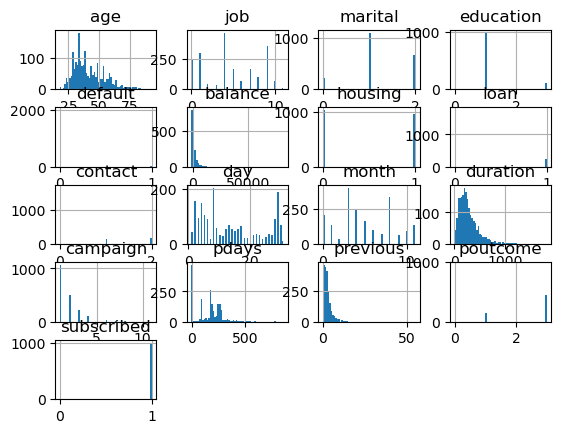

In [513]:
data_encoded.hist(bins=60)

In [514]:
# Fill missing values
imputer = SimpleImputer(strategy='mean')  # Use mean strategy to fill missing values
data_imputed = pd.DataFrame(imputer.fit_transform(data_encoded), columns=data_encoded.columns)

# explore the outcome
data_imputed.tail()

age  job  marital  education  default  balance  housing  loan  contact  \
1995  20.0  8.0      2.0        3.0      0.0   2785.0      0.0   0.0      0.0   
1996  28.0  0.0      2.0        1.0      0.0    127.0      0.0   0.0      0.0   
1997  81.0  5.0      1.0        0.0      0.0   1154.0      0.0   0.0      1.0   
1998  46.0  7.0      1.0        0.0      0.0   4343.0      1.0   0.0      2.0   
1999  40.0  2.0      1.0        1.0      0.0   6403.0      0.0   0.0      0.0   

       day  month  duration  campaign  pdays  previous  poutcome  subscribed  
1995  16.0   11.0     327.0       2.0   -1.0       0.0       3.0         1.0  
1996  16.0   11.0    1334.0       2.0   -1.0       0.0       3.0         1.0  
1997  17.0   11.0     231.0       1.0   -1.0       0.0       3.0         1.0  
1998  20.0   11.0     185.0       1.0   -1.0       0.0       3.0         1.0  
1999  22.0   11.0     208.0       2.0   -1.0       0.0       3.0         1.0

In [515]:
# Apply a scaler to rescale features
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_imputed), columns=data_imputed.columns)

# Check if the missing data filled successfully 
data_scaled.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
subscribed    0
dtype: int64

Great! There are no more missing data as seen above. So, we have sorted out the missing data.

We can now proceed with data preparation (preprocess_pipeline) using scikit-learn pipeline. 

In [516]:
# Define cyclical attribute encoder function
def encode_cyclical(data):
    """
    takes data as input and applies cyclical attribute encoding to the 'day' and 'month' columns.
    calculates the sine and cosine transformations for the day and month values respectively
    converting them into cyclical representations suitable for machine learning models
    modifies the input data by adding four new columns: 'day_sin', 'day_cos', 'month_sin', and 'month_cos'.
    
    """
    data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
    data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)
    data['month_sin'] = np.sin(2 * np.pi * data['month'].apply(lambda x: pd.to_datetime(x, format='%b').month) / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'].apply(lambda x: pd.to_datetime(x, format='%b').month) / 12)
    return data

# Define a pipeline for numerical data processing
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define a pipeline for categorical data processing
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Define the overall data preparation pipeline
data_preparation_pipeline = Pipeline([
    ('copy', None),  # Placeholder for data copy
    ('cyclical_encoder', FunctionTransformer(encode_cyclical)),
    ('processing', ColumnTransformer([
        ('numerical', numerical_pipeline, numerical_columns),
        ('categorical', categorical_pipeline, categorical_columns)
    ], remainder='passthrough'))
])

# Now, you can fit and transform your data using this pipeline
prepared_data = data_preparation_pipeline.fit_transform(data)

prepared_data

array([[-0.7689874093482072, -0.32636404875365255, -1.3235650954491536,
        ..., 'failure', 'apr', 'no'],
       [-0.21706473213485697, -0.2318086903297868, -1.3235650954491536,
        ..., 'failure', 'apr', 'no'],
       [1.3598572027604294, -0.12096169920451179, -1.3235650954491536,
        ..., 'failure', 'apr', 'no'],
       ...,
       [3.0944713311452445, -0.08294788956789009, 0.32426134715960475,
        ..., 'failure', 'sep', 'yes'],
       [0.33485794507849326, 0.9357583199378794, 0.6332288051487469, ...,
        'failure', 'sep', 'yes'],
       [-0.13821863539009266, 1.5938125035634312, 0.8392071104748416,
        ..., 'failure', 'sep', 'yes']], dtype=object)

FunctionTransformer applies cyclical attribute encoding. ColumnTransformer separates preprocessing for numerical and categorical columns. Pipelines manage numerical data with imputation and scaling and categorical data with imputation and encoding. These components are combined to create the overall data preparation pipeline.

The function encode_cyclical(data) applies cyclical encoding to cyclic attributes like 'day' and 'month'. It calculates the sine and cosine of the angles formed by these attributes, allowing the model to understand their cyclical nature without bias from their numerical values. This encoding preserves the cyclic relationship, ensuring that values like '31st day' and '1st day' are treated as close together, benefiting models that rely on continuity.

C:\Users\gjefi\AppData\Local\Temp\ipykernel_18236\3890339550.py:25: UserWarning: Trying to create polar plot on an Axes that does not have a polar projection.
  plt.polar(theta_sin, data['day'], color='blue', label='sin')
C:\Users\gjefi\AppData\Local\Temp\ipykernel_18236\3890339550.py:26: UserWarning: Trying to create polar plot on an Axes that does not have a polar projection.
  plt.polar(theta_cos, data['day'], color='red', label='cos')


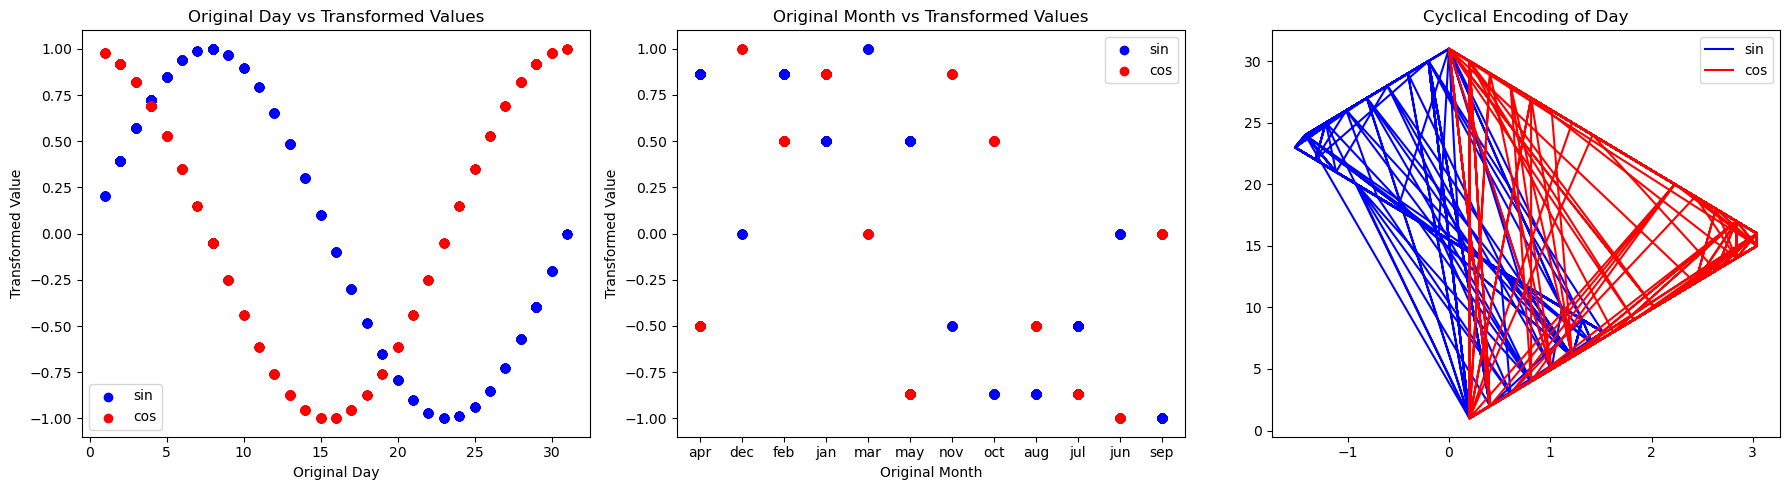

In [517]:
# Scatter plot of original 'day' values against 'day_sin' and 'day_cos'
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(data['day'], data['day_sin'], color='blue', label='sin')
plt.scatter(data['day'], data['day_cos'], color='red', label='cos')
plt.xlabel('Original Day')
plt.ylabel('Transformed Value')
plt.title('Original Day vs Transformed Values')
plt.legend()

# Scatter plot of original 'month' values against 'month_sin' and 'month_cos'
plt.subplot(1, 3, 2)
plt.scatter(data['month'], data['month_sin'], color='blue', label='sin')
plt.scatter(data['month'], data['month_cos'], color='red', label='cos')
plt.xlabel('Original Month')
plt.ylabel('Transformed Value')
plt.title('Original Month vs Transformed Values')
plt.legend()

# Polar plot showing 'day_sin' and 'day_cos'
plt.subplot(1, 3, 3)
theta_sin = np.arcsin(data['day_sin'])
theta_cos = np.arccos(data['day_cos'])
plt.polar(theta_sin, data['day'], color='blue', label='sin')
plt.polar(theta_cos, data['day'], color='red', label='cos')
plt.title('Cyclical Encoding of Day')
plt.legend()

plt.tight_layout()
plt.show()

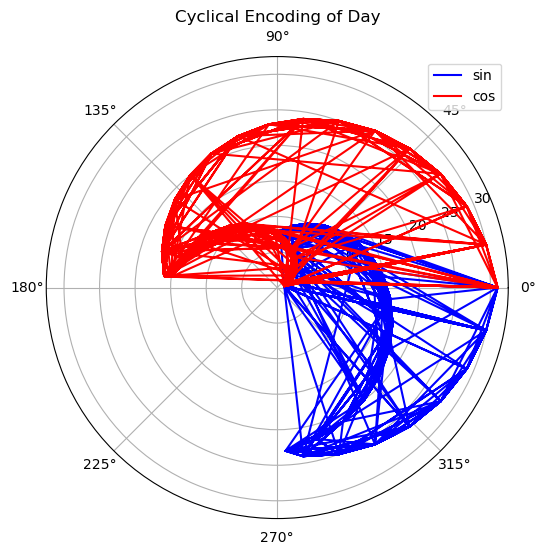

In [518]:
plt.figure(figsize=(6, 6))

theta_sin = np.arcsin(data['day_sin'])
theta_cos = np.arccos(data['day_cos'])

plt.polar(theta_sin, data['day'], color='blue', label='sin')
plt.polar(theta_cos, data['day'], color='red', label='cos')

plt.title('Cyclical Encoding of Day')
plt.legend()
plt.show()

### Another Solution (Alternatives)

In [519]:

# Custom transformer to encode categorical columns
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in X.columns:
            if X[col].dtype == 'object':
                X[col] = X[col].astype('category').cat.codes
        return X

# Define a function to encode cyclical attributes (day and month)
def encode_cyclical_attributes(data):
    data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
    data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)
    data['month_sin'] = np.sin(2 * np.pi * data['month'].apply(lambda x: pd.to_datetime(x, format='%b').month) / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'].apply(lambda x: pd.to_datetime(x, format='%b').month) / 12)
    return data

# Define numerical and categorical columns
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
target_column = 'subscribed'  # 'subscribed' is the target variable

# Define pipeline steps for numerical data
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine numerical and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', CategoricalEncoder(), categorical_columns)
])

# Define the main pipeline
pipeline = Pipeline([
    ('encode_cyclical', FunctionTransformer(encode_cyclical_attributes)),
    ('preprocessor', preprocessor)
])

# Separate features and target variable
X = data.drop(columns=[target_column])
y = data[target_column]

# Fit and transform the data
X_preprocessed = pipeline.fit_transform(X)

# Concatenate preprocessed features and target variable
Xy_preprocessed = pd.concat([pd.DataFrame(X_preprocessed), y.reset_index(drop=True)], axis=1)

# View result
Xy_preprocessed

0         1         2         3         4         5         6  \
0    -0.768987 -0.326364 -1.323565  3.002139  0.065650 -0.280107 -0.165153   
1    -0.217065 -0.231809 -1.323565 -0.266456  0.065650 -0.264923 -0.459280   
2     1.359857 -0.120962 -1.323565 -0.749522  0.065650  0.539807 -0.459280   
3     0.413704 -0.324447 -1.323565 -0.081356 -0.659767  0.532215 -0.165153   
4     0.965627 -0.130864 -1.323565  0.844144 -0.659767  1.056049 -0.459280   
...        ...       ...       ...       ...       ...       ...       ...   
1995 -1.715141  0.438065  0.221272  0.157920  0.065650 -1.282224 -0.753408   
1996 -1.084372 -0.411017  0.221272  4.704156  0.065650 -1.282224 -0.753408   
1997  3.094471 -0.082948  0.324261 -0.275485 -0.659767 -1.282224 -0.753408   
1998  0.334858  0.935758  0.633229 -0.483158 -0.659767 -1.282224 -0.753408   
1999 -0.138219  1.593813  0.839207 -0.379322  0.065650 -1.282224 -0.753408   

             7         8         9        10   11   12   13   14   15   16  \
0     0.000519  1.134552  0.944589 -0.617748  9.0  2.0  2.0  0.0  1.0  0.0   
1     0.000519  1.134552  0.944589 -0.617748  9.0  0.0  1.0  0.0  1.0  1.0   
2     0.000519  1.134552  0.944589 -0.617748  5.0  1.0  1.0  0.0  1.0  1.0   
3     0.000519  1.134552  0.944589 -0.617748  1.0  1.0  1.0  0.0  1.0  1.0   
4     0.000519  1.134552  0.944589 -0.617748  5.0  1.0  1.0  0.0  1.0  0.0   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
1995 -0.458040 -1.685240 -1.776645  0.106413  8.0  2.0 -1.0  0.0  0.0  0.0   
1996 -0.458040 -1.685240 -1.776645  0.106413  0.0  2.0  1.0  0.0  0.0  0.0   
1997 -0.758516 -1.627070 -1.776645  0.106413  5.0  1.0  0.0  0.0  0.0  0.0   
1998 -1.503530 -1.138586 -1.776645  0.106413  7.0  1.0  0.0  0.0  1.0  0.0   
1999 -1.772331 -0.622367 -1.776645  0.106413  2.0  1.0  1.0  0.0  0.0  0.0   

       17   18 subscribed  
0     0.0  0.0         no  
1     0.0  0.0         no  
2     0.0  0.0         no  
3     0.0  0.0         no  
4     0.0  0.0         no  
...   ...  ...        ...  
1995  0.0 -1.0        yes  
1996  0.0 -1.0        yes  
1997  1.0 -1.0        yes  
1998 -1.0 -1.0        yes  
1999  0.0 -1.0        yes  

[2000 rows x 20 columns]

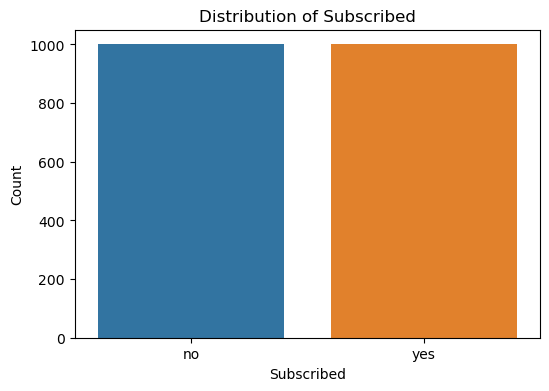

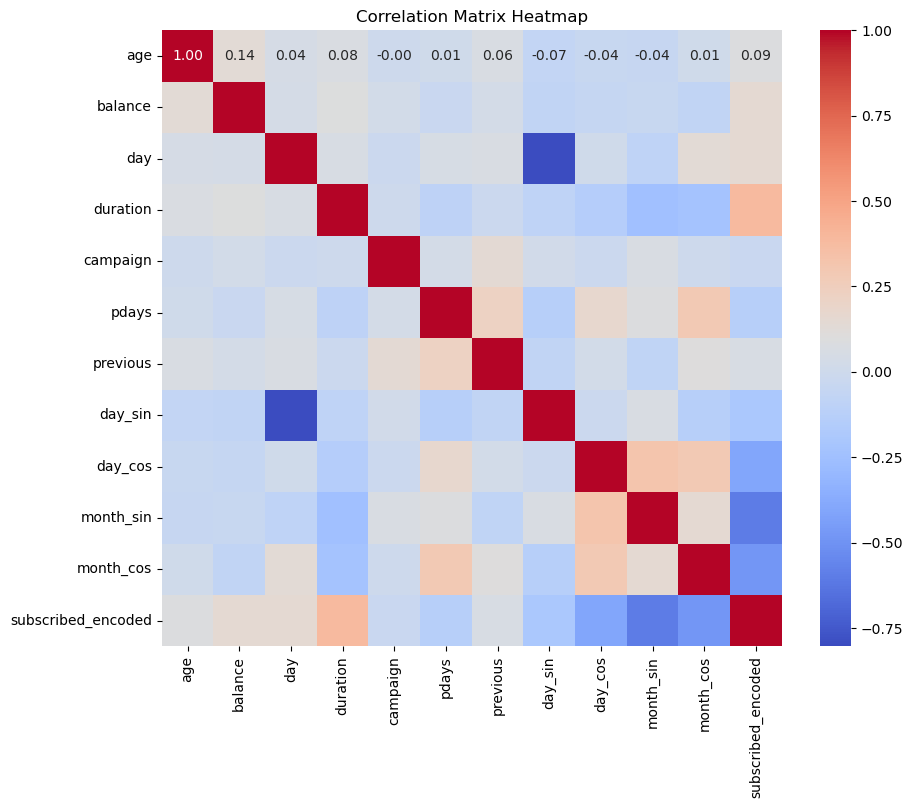

In [520]:
# Plot histogram for the target variable 'subscribed'
plt.figure(figsize=(6, 4))
sns.countplot(x='subscribed', data=data)
plt.title('Distribution of Subscribed')
plt.xlabel('Subscribed')
plt.ylabel('Count')
plt.show()

# Encode 'subscribed' column
data['subscribed_encoded'] = data['subscribed'].map({'yes': 1, 'no': 0})

# Plot correlation matrix heatmap for numerical features and target variable
numerical_features = numerical_columns + ['subscribed_encoded']  # Include encoded target variable
plt.figure(figsize=(10, 8))
corr = data[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

### Task 2: k-Means

- Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.
- Use the Silhouette Coefficient method to determine the best value of k as well.
- Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.
- Use MDS and t-SNE for visualising the clusterings.
- Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).

#### i. Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.

C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\clust

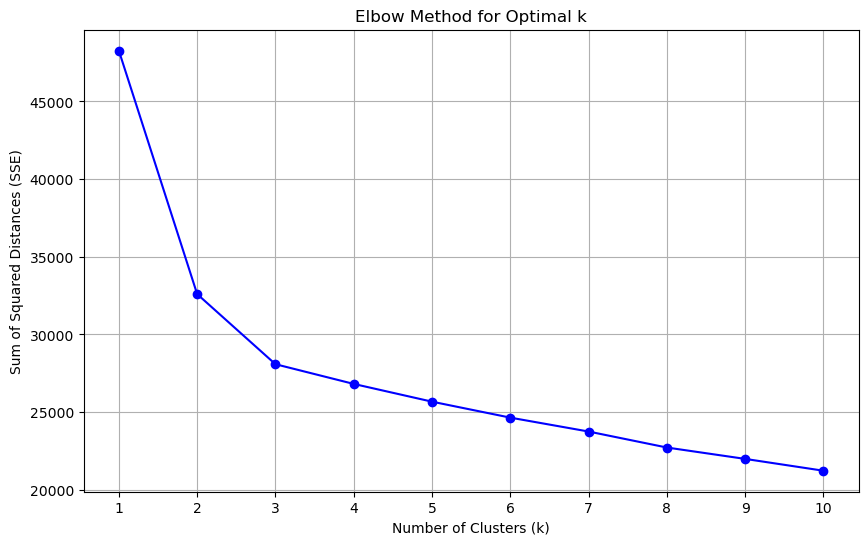

In [521]:
# Function to calculate sum of squared distances for k-Means clusters
def calculate_sse(X, k_max):
    sse = []
    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
    return sse

# Calculate sum of squared distances for various values of k
k_max = 10  # Maximum number of clusters to consider
sse = calculate_sse(X_preprocessed, k_max)

# Plot the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), sse, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.xticks(range(1, k_max + 1))
plt.grid(True)
plt.show()

#### ii. Use the Silhouette Coefficient method to determine the best value of k as well.

C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\clust

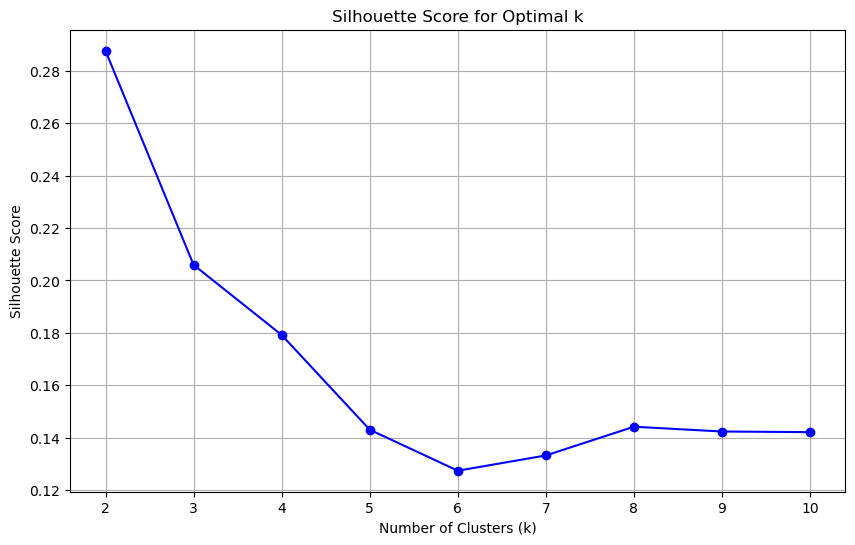

In [522]:
# Function to calculate silhouette score for k-Means clusters
def calculate_silhouette_score(X, k_max):
    silhouette_scores = []
    for k in range(2, k_max + 1):  # Silhouette score is not defined for k=1
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, labels))
    return silhouette_scores

# Calculate silhouette score for various values of k
silhouette_scores = calculate_silhouette_score(X_preprocessed, k_max)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, k_max + 1), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, k_max + 1))
plt.grid(True)
plt.show()

#### iii. Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.

In [523]:

# Choose the optimal value of k based on Elbow method or Silhouette Coefficient
# For example, let's choose k=3 based on the Elbow method
optimal_k = 3

# Perform k-Means clustering with the optimal value of k
kmeans = KMeans(n_clusters = optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_preprocessed)

# Add cluster labels to the dataset
data_clustered = data.copy()
data_clustered['cluster'] = cluster_labels

# # Analyze the clusters
# cluster_summary = data_clustered.groupby('cluster').mean()
# print(cluster_summary)

# Select only numeric columns for aggregation
numeric_columns = data.select_dtypes(include=['number']).columns

# Analyze the clusters
cluster_summary = data_clustered.groupby('cluster')[numeric_columns].mean()
print(cluster_summary)

C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


               age      balance        day    duration  campaign       pdays  \
cluster                                                                        
0        46.651261  1981.560333  14.446602  311.668516  1.940361  164.319001   
1        37.618343  1213.328424  14.150221  291.213549  1.902798  170.855670   
2        40.578595   957.953333  12.798333  269.323333  1.880000  168.845000   

         previous   day_sin   day_cos  month_sin  month_cos  \
cluster                                                       
0        2.886269  0.139494  0.095286   0.124189  -0.112141   
1        2.407953  0.186653  0.233180   0.235460  -0.063705   
2        2.345000  0.290999  0.238698   0.311953  -0.038062   

         subscribed_encoded  
cluster                      
0                  0.615811  
1                  0.484536  
2                  0.378333  


#### iv. Use MDS and t-SNE for visualising the clusterings.

C:\Users\gjefi\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


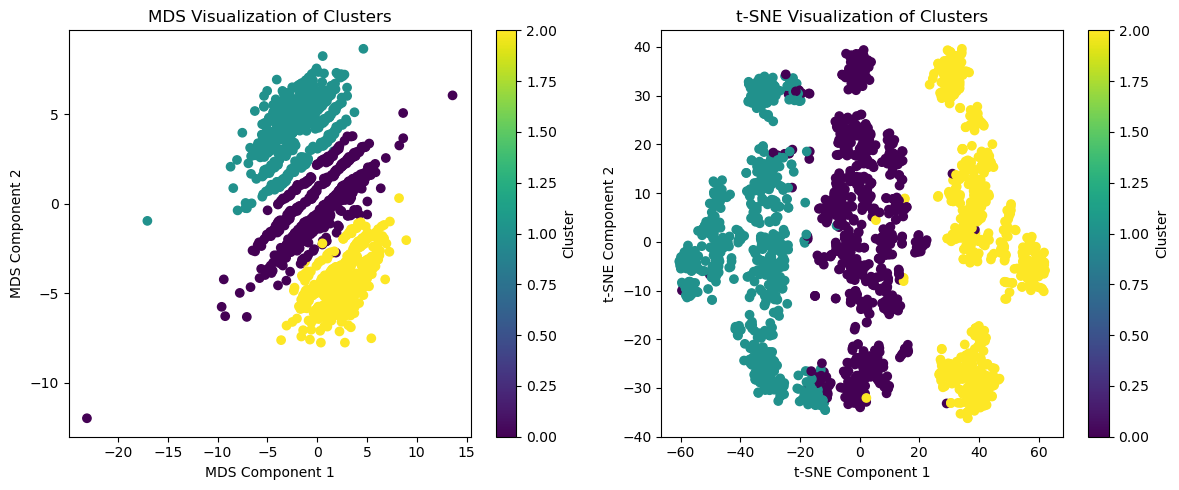

In [524]:
# Perform MDS
mds = MDS(n_components=2, random_state=42)
mds_transformed = mds.fit_transform(X_preprocessed)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(X_preprocessed)

# Plot MDS
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(mds_transformed[:, 0], mds_transformed[:, 1], c=cluster_labels, cmap='viridis')
plt.title('MDS Visualization of Clusters')
plt.xlabel('MDS Component 1')
plt.ylabel('MDS Component 2')
plt.colorbar(label='Cluster')

# Plot t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=cluster_labels, cmap='viridis')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

### Task 3: DBSCAN

- Apply the DBSCAN clustering algorithm to the prepared bank dataset.
- Use MDS and t-SNE for visualising the clustering.
- Write a short conclusion about the characteristics of the clusters and compare the performance of DBSCAN to k-Means. (max 250 words in a markdown cell).